# Connected Component Labelling

Este notebook utiliza la técnica de etiquetado de componentes conectados para poder extraer features morfológicos de los granos de arroz.

In [2]:
# General
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import math
import random
from collections import Counter

# Imagen
import cv2
from skimage import measure
import skimage

# Normalización
from sklearn.preprocessing import StandardScaler

# Reducción de Dimensionalidad
from umap import UMAP
from sklearn.decomposition import PCA

# Kmeans
from sklearn.cluster import KMeans

# Metricas
from sklearn.metrics import rand_score, adjusted_rand_score


# warnings
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

In [5]:
import re

def get_labels_and_paths(input_folder):
   return sorted([(dp.split("\\")[1],os.path.join(dp, f)) for dp, dn, filenames in os.walk('input') for f in filenames if os.path.splitext(f)[1] == '.jpg'])

def img_to_numpy(path, grayscale=False): 
    img = cv2.imread(filename=path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if grayscale:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return img

def binarizado(img, thresh=None):
    img_binary = cv2.threshold(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), 
                               thresh, 255, cv2.THRESH_BINARY)
    return img_binary[1]


def vanDongen(ct):
    n2=2*(sum(ct.apply(sum,axis=1)))
    sumi = sum(ct.apply(np.max,axis=1))
    sumj = sum(ct.apply(np.max,axis=0))
    maxsumi = np.max(ct.apply(sum,axis=1))
    maxsumj = np.max(ct.apply(sum,axis=0))
    vd = (n2 - sumi - sumj)/(n2 - maxsumi - maxsumj)
    return vd

def cross_tab(Labels_orig, Labels_clust):
     '''crea matriz de confusión para evaluar etiquetado
     labels_orig  = etiquetas originales - reales
     labels_test  = etiquetas halladeas por el algoritmo'''
     tmp = pd.DataFrame({'Labels_orig': Labels_orig, 'Labels_clust': Labels_clust})
     ct = pd.crosstab(tmp['Labels_clust'],tmp['Labels_orig']) # Create crosstab: ct
     rand = rand_score(Labels_orig, Labels_clust)
     arand= adjusted_rand_score(Labels_orig, Labels_clust)
     vandon = vanDongen(ct)
     print(f'RAND score={rand:.4f}, Ajusted RAND={arand:.4f}, vanDongen={vandon:.4f} cantidad_de_muestras={len(Labels_orig):,d}')
     return ct, rand, arand, vandon


def features_morfologicos(imagen_binaria, properties=None):
    label_img = measure.label(imagen_binaria)
    props_table = measure.regionprops_table(label_img, properties=properties)
    return props_table

def generate_features(class_name, filepath, feature_list=None):
    img = img_to_numpy(filepath)
    img_binary = binarizado(img, thresh=100)
    props_table = features_morfologicos(imagen_binaria=img_binary, properties=feature_list)
    props_table['class_name'] = class_name
    num_id = re.search("\d+", filepath.split("/")[-1])[0]
    props_table['image_id'] = f"{class_name.lower()} ({num_id}).jpg"
    return pd.DataFrame(props_table)


def seleccionar_muestra(sample_length = None, input_folder="output/datasets/", prefijo="features_completos_", sufijo=".csv.gz"):
    DEFAULT_LENGTH = 15000 
    
    clases = ["Arborio", "Basmati", "Ipsala", "Jasmine", "Karacadag"]
       
    sample_df = pd.DataFrame()
    for clase in clases:
        path = input_folder+prefijo+clase+sufijo
        ids = np.random.choice(np.arange(0,DEFAULT_LENGTH,1), size=sample_length, replace=False)
        df = pd.read_csv(path) 
        df = df.loc[ids, :].reset_index(drop=True)
        sample_df = pd.concat([sample_df, df], axis=0)
    print(f"Stratified Sample of {sample_df.shape[0]}")
    return sample_df 

     
def hacer_reduccion(X:pd.DataFrame, normalizacion:bool, metodo:str, umap_params:dict):

    # method : str puede ser 'pca', 'umap', 'both'
    # umap_params: dict {'n_neighbors':int, 'min_dist':float, 'n_components':int, 'metric':str}
    
    if normalizacion: 
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    
    if (metodo == "pca") or (metodo == 'both'):
        print("Reduction Method PCA") 
        DEFAULT_MIN_COMP = 100
        ncols = X.shape[1]
        n_components = np.min([DEFAULT_MIN_COMP, ncols])

        pca = PCA(n_components=n_components)
        scaled_pca = pca.fit(X)
        X = pca.transform(X)

    elif (metodo == 'umap') or (metodo == 'both'): 
        print("Reduction Method UMAP") 
        if umap_params:
            n_neighbors = umap_params['n_neighbors']
            min_dist = umap_params['min_dist']
            n_components = umap_params['n_components']
            metric = umap_params['metric']
            umap = UMAP(n_neighbors=n_neighbors,
                        min_dist=min_dist,
                        n_components=n_components,
                        metric=metric)
        else:
            umap = UMAP()
        X = umap.fit_transform(X)
    else: 
        raise ValueError("El parámetro 'metodo' solo acepta  'pca', 'umap', 'both'") 

    return X       

In [79]:
INPUT_FOLDER = "input/"
labels_and_paths = get_labels_and_paths(input_folder=INPUT_FOLDER)
input_paths = np.array([x[1] for x in labels_and_paths])
labels = np.array(x[0] for x in labels_and_paths) 

label_names = pd.DataFrame(labels_and_paths, columns=["name","file"])
label_names['label'] = label_names['name'].map({"Arborio":0,
                                                "Basmati":1,
                                                "Ipsala":2,
                                                "Jasmine":3,
                                                "Karacadag":4})

In [80]:
# Contar las clases
class_counts = Counter(item[0] for item in labels_and_paths)

# Calcular la cantidad mínima de elementos por clase
min_count = 1

total_samples = min_count * len(class_counts)

# Crear una lista de elementos por clase
grouped_data = {key: [item for item in labels_and_paths if item[0] == key] for key in class_counts.keys()}

# Tomar una muestra estratificada
stratified_sample = []
for key, group in grouped_data.items():
    random.shuffle(group)  # Mezcla los elementos para obtener una muestra aleatoria
    stratified_sample.extend(group[:min_count])  # Agrega la misma cantidad de elementos por clase

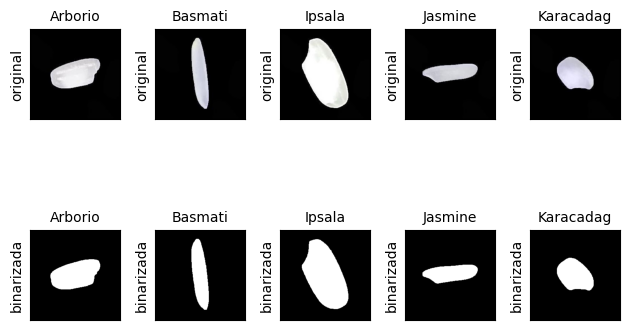

In [81]:
fig, axs = plt.subplots(ncols=len(stratified_sample),nrows=2, sharey=True, sharex=True)
axs1, axs2 = axs.reshape(2,-1)
for (label,path),ax1,ax2 in zip(stratified_sample, axs1, axs2):
    img = img_to_numpy(path=path)
    ax1.imshow(img)
    ax1.set_title(f"{label}", fontsize=10)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_ylabel("original")
    img_binary = binarizado(img, thresh=100)
    ax2.imshow(img_binary, cmap="gray")
    ax2.set_title(f"{label}", fontsize=10)
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_ylabel('binarizada')

plt.tight_layout()
plt.show()



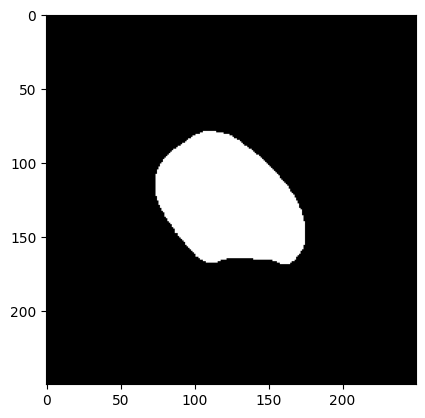

In [82]:
label_im = measure.label(img_binary)
regions = measure.regionprops(label_image=label_im)
plt.imshow(label_im, cmap="gray")
plt.show()

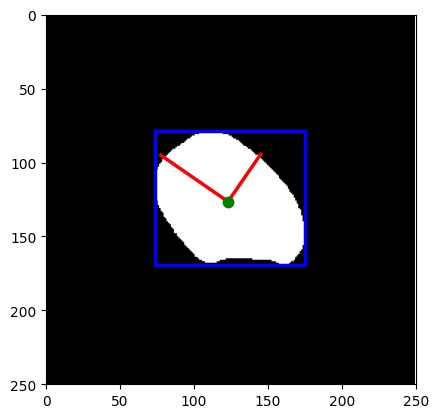

In [83]:
fig, ax = plt.subplots()
ax.imshow(img_binary, cmap=plt.cm.gray)

for props in regions:
    y0, x0 = props.centroid
    orientation = props.orientation
    x1 = x0 + math.cos(orientation) * 0.5 * props.axis_minor_length
    y1 = y0 - math.sin(orientation) * 0.5 * props.axis_minor_length
    x2 = x0 - math.sin(orientation) * 0.5 * props.axis_major_length
    y2 = y0 - math.cos(orientation) * 0.5 * props.axis_major_length

    ax.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
    ax.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
    ax.plot(x0, y0, '.g', markersize=15)

    minr, minc, maxr, maxc = props.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax.plot(bx, by, '-b', linewidth=2.5)

ax.axis((0, 250, 250, 0))
plt.show()

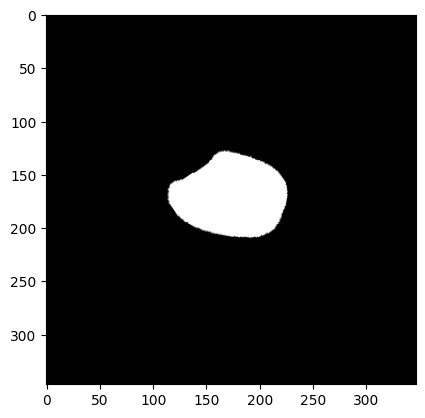

In [134]:
# Se le puede cambiar la rotación ojaldreeee

orientation = measure.regionprops_table(label_im, properties=['orientation'])['orientation'][0]
angle_in_degrees = orientation * (180/np.pi) + 90 


from skimage.transform import rotate
rotated = rotate(img_binary, -angle_in_degrees, resize=True)

plt.imshow(rotated, cmap="gray")

In [128]:
properties = ['area','eccentricity','perimeter',
              'orientation','axis_major_length','axis_minor_length']

props_table = measure.regionprops_table(label_im, properties=properties)

pd.DataFrame(props_table)

,area,eccentricity,perimeter,orientation,axis_major_length,axis_minor_length
0,6616.0,0.709213,315.462987,0.967023,110.15154,77.656248


In [9]:
features_list = ['area','eccentricity','perimeter', 
              'orientation','axis_major_length','axis_minor_length']

X = pd.DataFrame()
for class_name, path in tqdm(labels_and_paths):
    x = generate_features(class_name=class_name, filepath=path, feature_list=features_list)
    X = pd.concat([X, x], axis=0)


  0%|          | 0/75000 [00:00<?, ?it/s]

100%|██████████| 75000/75000 [19:20<00:00, 64.64it/s] 


In [11]:
X.to_csv("outputs/datasets/features_morfologicos.csv.gz", index=False)

### Exploración atributos morfológicos

In [67]:
df = pd.read_csv("outputs/datasets/features_morfologicos.csv.gz").drop(columns='image_id')

melted = df.melt(id_vars='class_name', var_name="atributo", value_name='valor')

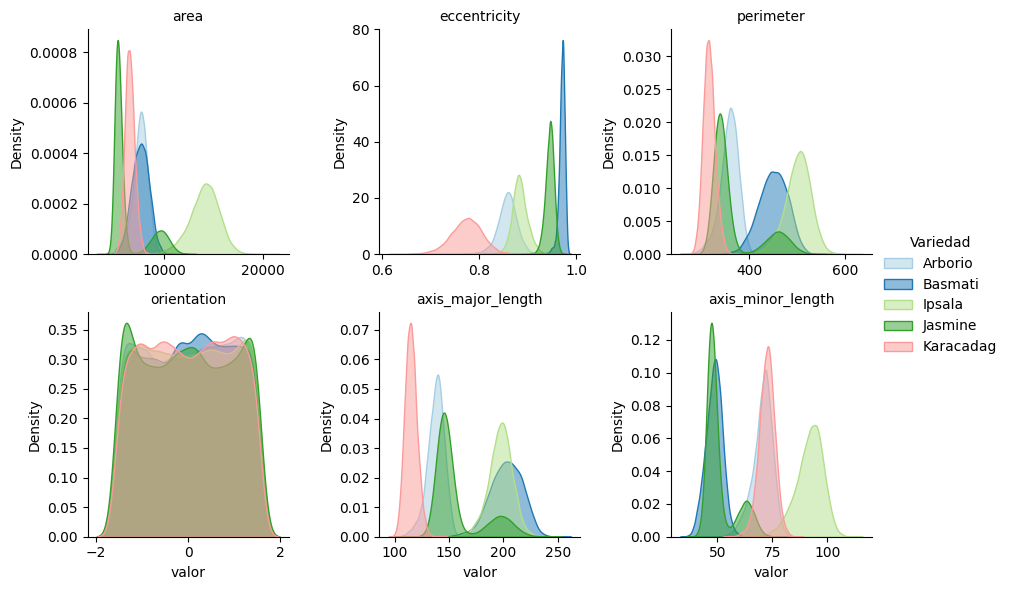

In [97]:
g = sns.FacetGrid(data=melted, col="atributo", hue="class_name",col_wrap=3, sharey=False, sharex=False, palette='Paired')
g.map_dataframe(sns.kdeplot, x="valor", linewidth=1, fill=True, alpha=0.5)
g.set_titles(col_template="{col_name}")
g.add_legend(title="Variedad")
plt.show()

### Estudio con K-means

In [3]:
# sample_by_class = 3000

X = pd.read_csv("outputs/datasets/features_morfologicos.csv.gz")
# X = X.groupby('class_name').apply(lambda x: x.sample(sample_by_class, replace=False)).reset_index(drop=True)

image_id = X.image_id.to_list()
true_labels = X.class_name.to_list()
X = X.drop(columns=['image_id','class_name'])

from sklearn.model_selection import train_test_split

# separo en train_test y validación con sus respectivas etiquetas y los mezclo
X_train_test, X_val, y_train_test, y_val = train_test_split(X, true_labels, test_size=0.2, random_state=42)

In [8]:
# PCA

# Hago con 100 componentes
Xpca = hacer_reduccion(X=X_train_test, normalizacion=True, metodo="pca", umap_params=None)

kmeans = KMeans(n_clusters=3, random_state=42, init='k-means++', n_init='auto')
kmeans.fit(Xpca)

pca_km_labels = kmeans.labels_

ct1, rand, arand, vandon = cross_tab(Labels_orig=y_train_test, Labels_clust=pca_km_labels)


Reduction Method PCA
RAND score=0.8341, Ajusted RAND=0.6009, vanDongen=0.2936 cantidad_de_muestras=60,000


In [13]:
ct1

Labels_orig,Arborio,Basmati,Ipsala,Jasmine,Karacadag
Labels_clust,,,,,
0,0,1,11817,266,0
1,11949,0,44,72,12071
2,54,12004,56,11666,0


Text(0, 0.5, 'SSE para KMeans (euclidea) con PCA')

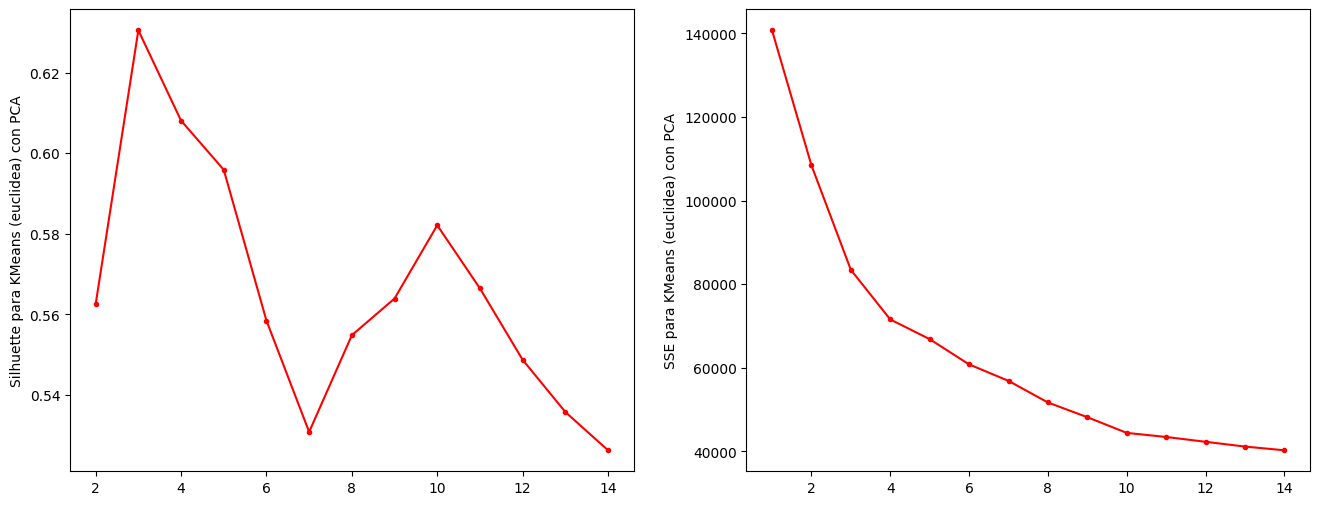

In [7]:
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.utils.metric import type_metric, distance_metric
from pyclustering.cluster.silhouette import silhouette
from pyclustering.cluster.kmeans import kmeans
from pyclustering import utils

range_k = [i for i in range(1,15)]
silh_euc = []
sse_euc = []
for k in range_k:
    
    kmeans_centers = KMeans(n_clusters=k, random_state=10, n_init='auto', init='k-means++')
    kmeans_centers.fit(Xpca)
    centers = kmeans_centers.cluster_centers_

    metrica_elegida = distance_metric(type_metric.EUCLIDEAN)

    kmeans_instance = kmeans(Xpca, centers, metric=metrica_elegida);
    kmeans_instance.process()
    clusters = kmeans_instance.get_clusters()
    
    silh_euc.append(np.mean(silhouette(Xpca, clusters).process().get_score()))
    sse_euc.append(kmeans_instance.get_total_wce())
    
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(range_k,silh_euc,'r.-')
plt.ylabel('Silhuette para KMeans (euclidea) con PCA')
plt.subplot(1,2,2)
plt.plot(range_k,sse_euc,'r.-')
plt.ylabel('SSE para KMeans (euclidea) con PCA')

In [16]:
# UMAP 

umap_params = {
    'n_neighbors': 20,
    'min_dist': 0.0,
    'n_components':2,
    'metric':'euclidean'
}

Xumap = hacer_reduccion(X=X_train_test, normalizacion=True, metodo="umap", umap_params=umap_params)

kmeans = KMeans(n_clusters=4, random_state=42, init='k-means++', n_init='auto')
kmeans.fit(Xumap)

umap_km_labels = kmeans.labels_

ct2, rand, arand, vandon = cross_tab(Labels_orig=y_train_test, Labels_clust=umap_km_labels)


Reduction Method UMAP
RAND score=0.8849, Ajusted RAND=0.6893, vanDongen=0.2120 cantidad_de_muestras=60,000


In [17]:
ct2

Labels_orig,Arborio,Basmati,Ipsala,Jasmine,Karacadag
Labels_clust,,,,,
0,1,0,11834,21,0
1,11954,3,35,9,12071
2,1,11877,48,2622,0
3,47,125,0,9352,0


In [10]:
def grafico_evaluacion(X_train_test, labels_orig, labels_test , nom_test=''):
    '''grafico en el espacio vectorial del pca las clasificaciones realizadas
    X_train_test = coordenadas de lso puntos en PCA -considera slo las primeras 4-
    labels_orig  = etiquetas originales - reales
    labels_test  = etiquetas halladeas por el algoritmo
    nom_test     = texto para aclara en el grafico el nombre del clasificador utilizado
    '''
    
    # cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', plt.cm.tab20(np.arange(5)), 5)

    fig, axs = plt.subplots(1,2, figsize=(4,2))
    sns.scatterplot(x = X_train_test[:,0],y = X_train_test[:,1], hue = labels_test, alpha=0.5, ax=axs[0])
    # axs[0].scatter(X_train_test[:,0],X_train_test[:,1],s=0.5,c=labels_test, alpha=0.5, cmap=cmap)

    sns.scatterplot(x = X_train_test[:,0],y = X_train_test[:,1], hue = labels_orig, alpha=0.5, ax=axs[1])        
    # axs[1].scatter(X_train_test[:,0],X_train_test[:,1],s=0.5,c=labels_orig, alpha=0.5, cmap=cmap)
    
    sns.move_legend(axs[0], "upper left", bbox_to_anchor=(1, 1))
    sns.move_legend(axs[1], "upper left", bbox_to_anchor=(1, 1))

    axs[0].axis('off')
    axs[1].axis('off')
    axs[0].set_title(f'{nom_test}')
    axs[1].set_title('real')
    fig.set_constrained_layout('constrained')
    return None

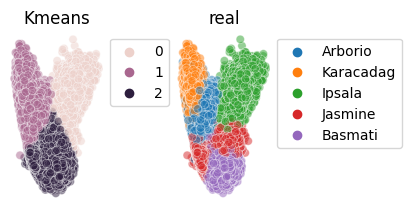

In [13]:
grafico_evaluacion(Xpca, y_train_test, pca_km_labels, nom_test = "Kmeans")

Text(0, 0.5, 'SSE para KMeans (euclidea) con UMAP')

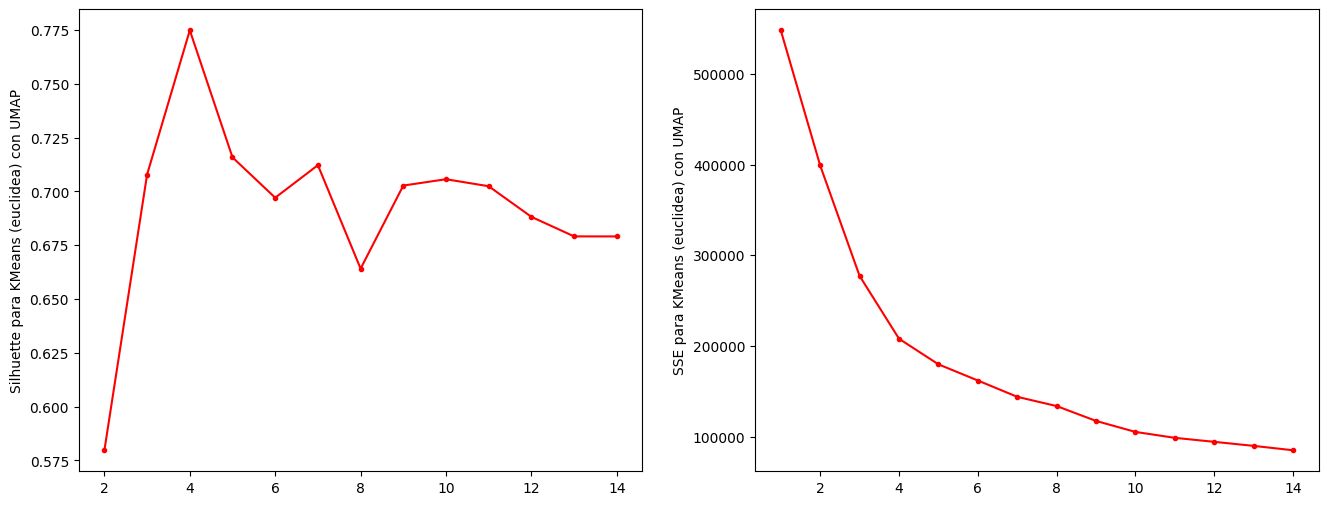

In [15]:
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.utils.metric import type_metric, distance_metric
from pyclustering.cluster.silhouette import silhouette
from pyclustering.cluster.kmeans import kmeans
from pyclustering import utils

range_k = [i for i in range(1,15)]
silh_euc = []
sse_euc = []
for k in range_k:
    
    kmeans_centers = KMeans(n_clusters=k, random_state=10, n_init='auto', init='k-means++')
    kmeans_centers.fit(Xumap)
    centers = kmeans_centers.cluster_centers_

    metrica_elegida = distance_metric(type_metric.EUCLIDEAN)

    kmeans_instance = kmeans(Xumap, centers, metric=metrica_elegida);
    kmeans_instance.process()
    clusters = kmeans_instance.get_clusters()
    
    silh_euc.append(np.mean(silhouette(Xumap, clusters).process().get_score()))
    sse_euc.append(kmeans_instance.get_total_wce())
    
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(range_k,silh_euc,'r.-')
plt.ylabel('Silhuette para KMeans (euclidea) con UMAP')
plt.subplot(1,2,2)
plt.plot(range_k,sse_euc,'r.-')
plt.ylabel('SSE para KMeans (euclidea) con UMAP')

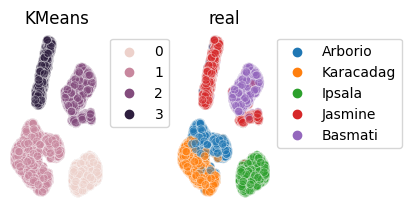

In [18]:
grafico_evaluacion(Xumap, y_train_test, umap_km_labels, nom_test='KMeans')